# False Positive / False Negative Investigation for Embeddings Data using Reference Distances

## Data preparation

Uses both MNIST and Extended MNIST Letters (included as CSV in branch). Assume the task is predicting digits (0-9), so false negatives in our dataset will be numbers and false positives alphabetic characters.

In [1]:
import os
import numpy as np
import pandas as pd
import pickle
from string import ascii_uppercase
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split

In [2]:
# Load MNIST dataset (70k rows)
if os.path.exists("mnist_784_X_y.pkl"):
    print("Data found locally.")
    X_numeric, y_numeric = pickle.load(open("mnist_784_X_y.pkl", 'rb'))
else:
    X_numeric, y_numeric = fetch_openml("mnist_784", version=1, return_X_y=True, as_frame=False)

In [3]:
# Load Extended MNIST alpha dataset (limit to 30k rows)
if os.path.exists("emnist-letters-train.csv"):
    print("Data found locally.")
    exMNIST = pd.read_csv("emnist-letters-train.csv", header=None).sample(70000)
else:
    pd.read_csv("https://whylabs-public.s3.us-west-2.amazonaws.com/datasets/mnist/emnist-letters-train.csv", header=None).sample(70000)

X_alpha = exMNIST.drop(0, axis=1).values
y_alpha = exMNIST[0].apply(lambda x: ascii_uppercase[x-1]).values

In [5]:
# Create false positives and false negatives (from training data)
np.random.seed(1065)
false_negative_idx = np.random.choice(len(X_numeric), 7000)
false_positive_idx = np.random.choice(len(X_alpha), 7000)

X_false_negatives = X_numeric[false_negative_idx, :]
y_false_negatives = y_numeric[false_negative_idx]
X_false_positives = X_alpha[false_positive_idx, :]
y_false_positives = y_alpha[false_positive_idx]

In [4]:
# Split into training and production datasets
X_train, X_prod, y_train, y_prod = train_test_split(np.concatenate([X_numeric, X_alpha]), np.concatenate([y_numeric, y_alpha]), test_size=0.25)

In [6]:
# Calculate references for your false positive and false negative embeddings
from whylogs.experimental.preprocess.embeddings.selectors import PCAKMeansSelector

fp_references, fp_labels = PCAKMeansSelector(n_clusters=8, n_components=20).calculate_references(X_false_positives)
fp_labels = ["fp_" + str(s) for s in fp_labels]
fn_references, fn_labels = PCAKMeansSelector(n_clusters=8, n_components=20).calculate_references(X_false_negatives)
fn_labels = ["fn_" + str(s) for s in fn_labels]

In [7]:
# Give reference IDs to your production data
ids = np.arange(len(X_prod))
id_vector_tuples = np.column_stack((ids, X_prod))

## Profiling with whylogs

As with other advanced features, we can create a `DeclarativeSchema` to tell whylogs to resolve columns of a certain name to the `EmbeddingMetric` that we want to use.

We must pass our references, labels, and preferred distance function (either cosine distance or Euclidean distance) as parameters to `EmbeddingConfig` then log as normal.

In [8]:
from typing import Optional, Tuple
import whylogs as why
from whylogs.core.resolvers import MetricSpec, ResolverSpec
from whylogs.core.schema import DeclarativeSchema
from whylogs.experimental.extras.embedding_metric import (
    DistanceFunction,
    EmbeddingConfig,
    EmbeddingMetric,
)

fp_config = EmbeddingConfig(
    references=fp_references,
    labels=fp_labels,
    distance_fn=DistanceFunction.euclidean,
)

fn_config = EmbeddingConfig(
    references=fn_references,
    labels=fn_labels,
    distance_fn=DistanceFunction.euclidean,
)

schema = DeclarativeSchema(
    [ResolverSpec(column_name="pixel_values", metrics=[MetricSpec(EmbeddingMetric, fp_config), MetricSpec(EmbeddingMetric, fn_config)])],
)

train_profile = why.log(row={"pixel_values": X_train}, schema=schema)

In [9]:
train_profile

Let's confirm the contents of our profile measures the distribution of embeddings relative to the references we've provided.

## Measuring embeddings drift in WhyLabs

This distance approach can be really powerful for measuring drift across new batches of embeddings in a programmatic way using drift metrics as well as the WhyLabs Observability Platform.

We'll look at a single example where an engineer introduces a change to reduce the amount of unnecessary processing by filtering out images where more than 90% of pixels are zeros. This is a realistic cleaning step that might be added to an ML pipeline, but will have a detrimental impact on our incoming data, especially the 1s.

In [15]:
# Log production digits using the same schema but with UDF for row IDs
from whylogs.experimental.core.metrics.udf_metric import (
    generate_udf_schema,
    register_metric_udf,
)

def embeddings_outliers(indexed_vectors: Tuple[int, np.ndarray],
                        embedding_references: np.ndarray,
                        DISTANCE_THRESHOLD = 2000) -> Optional[str]:
    from sklearn.metrics.pairwise import cosine_distances, euclidean_distances

    matrix = id_vector_tuples.T[1:]
    row_ids = id_vector_tuples.T[0]

    # First, make sure single embeddings are in a 2D matrix (1 row, columns = embedding dims)
    if len(matrix.shape) == 1:
        matrix = matrix.reshape((1, matrix.shape[0]))
    outlier_row_ids = []
    min_d = None
    for i in range(len(row_ids)):
        row_id = row_ids[i]
        vector = matrix.T[i]
        reference_distances = euclidean_distances([vector], embedding_references)
        if min_d is None:
            min_d = reference_distances.min()
        else:
            min_d = min(min_d, reference_distances.min())
        outlier_distances = reference_distances < DISTANCE_THRESHOLD
        if outlier_distances.any():
            outlier_row_ids.append(row_id)

    if outlier_row_ids:
        return str(outlier_row_ids)[1:-1]
    return min_d

@register_metric_udf(col_name="id_vector_tuple")
def false_positive_outliers(indexed_vectors: Tuple[int, np.ndarray],
                            embedding_references: np.ndarray = fp_references,
                            DISTANCE_THRESHOLD = 2000) -> Optional[str]:
    return embeddings_outliers(indexed_vectors, embedding_references, DISTANCE_THRESHOLD)

@register_metric_udf(col_name="id_vector_tuple")
def false_negative_outliers(indexed_vectors: Tuple[int, np.ndarray],
                            embedding_references: np.ndarray = fn_references,
                            DISTANCE_THRESHOLD = 2000) -> Optional[str]:
    return embeddings_outliers(indexed_vectors, embedding_references, DISTANCE_THRESHOLD)

schema = DeclarativeSchema(
    [ResolverSpec(column_name="pixel_values", metrics=[MetricSpec(EmbeddingMetric, fp_config)])] + generate_udf_schema(),
)


In [16]:
prod_profile_view = why.log(row={"pixel_values": X_prod, "id_vector_tuple": id_vector_tuples}, schema=schema).profile().view()

In [17]:
summary = prod_profile_view.get_column("id_vector_tuple").to_summary_dict()
summary

{'udf/false_positive_outliers:counts/n': 1,
 'udf/false_positive_outliers:counts/null': 0,
 'udf/false_positive_outliers:counts/nan': 0,
 'udf/false_positive_outliers:counts/inf': 0,
 'udf/false_positive_outliers:types/integral': 0,
 'udf/false_positive_outliers:types/fractional': 0,
 'udf/false_positive_outliers:types/boolean': 0,
 'udf/false_positive_outliers:types/string': 1,
 'udf/false_positive_outliers:types/object': 0,
 'udf/false_positive_outliers:types/tensor': 0,
 'udf/false_positive_outliers:distribution/mean': 0.0,
 'udf/false_positive_outliers:distribution/stddev': 0.0,
 'udf/false_positive_outliers:distribution/n': 0,
 'udf/false_positive_outliers:distribution/max': nan,
 'udf/false_positive_outliers:distribution/min': nan,
 'udf/false_positive_outliers:distribution/q_01': None,
 'udf/false_positive_outliers:distribution/q_05': None,
 'udf/false_positive_outliers:distribution/q_10': None,
 'udf/false_positive_outliers:distribution/q_25': None,
 'udf/false_positive_outlier

The WhyLabs platform now contains row IDs for the values that are close to to False Positives and False Negatives respectively. You can see them in the Profiles tab for the data batches of interest.

For example, looking at the top three of each above:

Values found closest to False Negative references


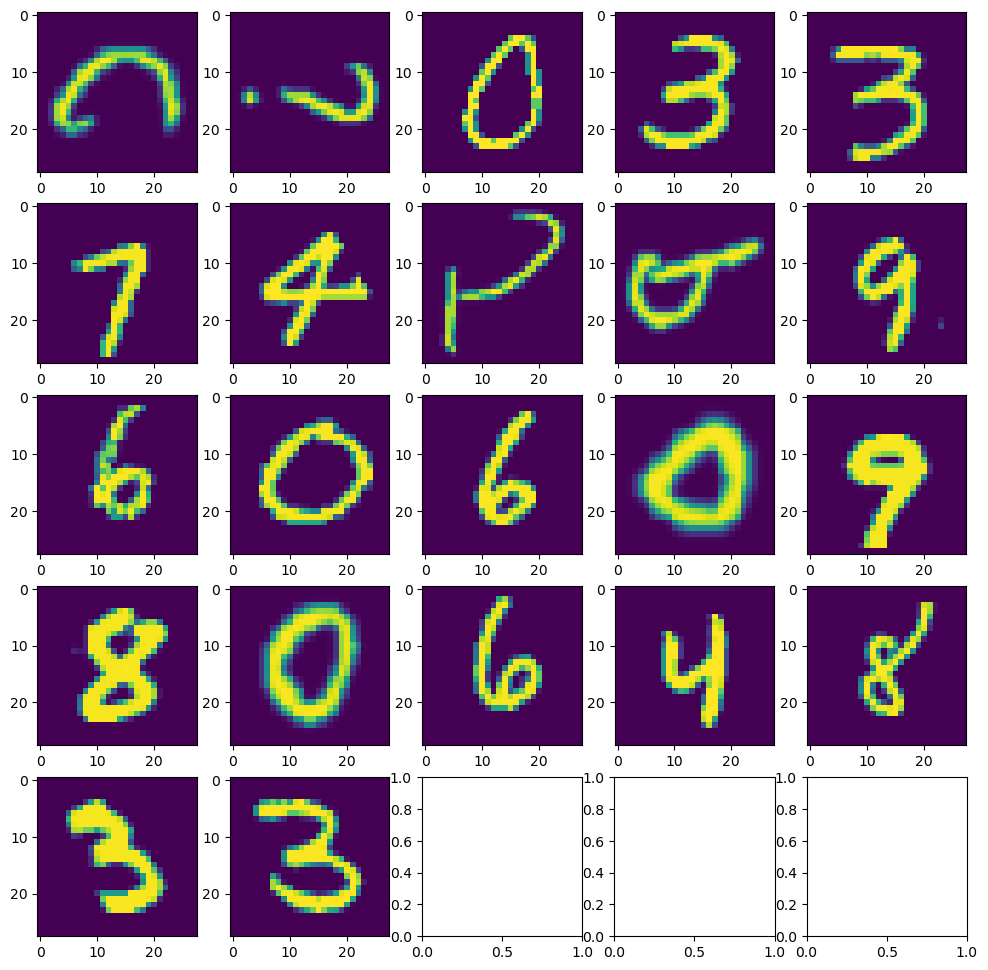

In [26]:
from matplotlib import pyplot as plt

false_negative_ids = [int(float(x.strip())) for x in summary["udf/false_negative_outliers:frequent_items/frequent_strings"][0].value.split(',')[:-1]]

print("Values found closest to False Negative references")
_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(X_prod[false_negative_ids, :].reshape((-1, 28,28)), axs):
    ax.imshow(img)
plt.show()

Values found closest to False Positive references


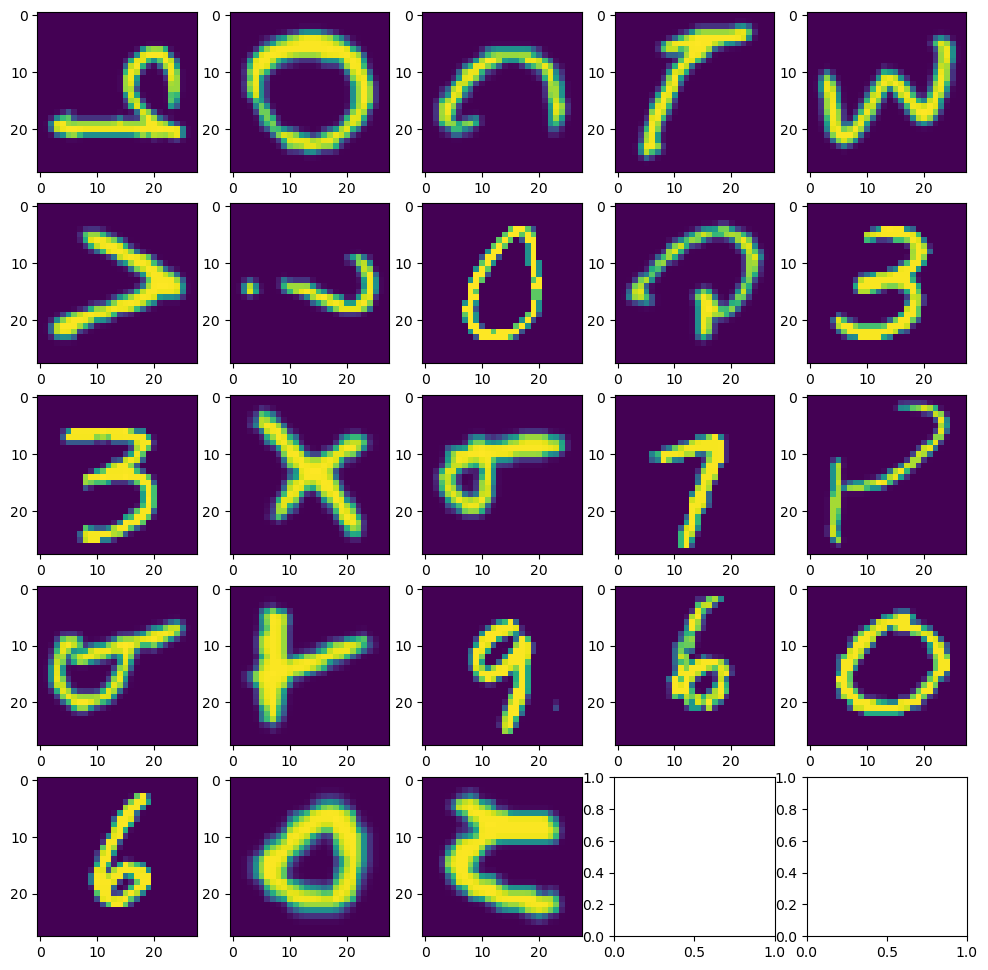

In [25]:
false_positive_ids = [int(float(x.strip())) for x in summary["udf/false_positive_outliers:frequent_items/frequent_strings"][0].value.split(',')]
print("Values found closest to False Positive references")
_, axs = plt.subplots(5, 5, figsize=(12, 12))
axs = axs.flatten()
for img, ax in zip(X_prod[false_positive_ids, :].reshape((-1, 28,28)), axs):
    ax.imshow(img)
plt.show()